In [15]:
"""
Utility functions for contructing paths and finding files for CMIP6 data
Leif Denby, v3, 24/5/2021
Historical runs (1850-2014) are in 
`<data_root>/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
Scenario runs are in
`<data_root>/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
"""

from pathlib import Path
from enum import Enum


# computing centre dictionary
INSTITUTES = {
    "UKESM1-0-LL": "MOHC",
    "CNRM-CM6-1": "CNRM-CERFACS",
    "MRI-ESM2-0": "MRI",
    "GFDL-CM4": "NOAA-GFDL",
    "GISS-E2-1-G": "NASA-GISS",
    "HadGEM3-GC31-LL": "MOHC",
    "TaiESM1": "AS-RCEC",
    "AWI-CM-1-1-MR": "AWI",
    "BCC-CSM2-MR": "BCC",
    "BCC-ESM1": "BCC",
    "CAMS-CSM1-0": "CAMS",
    "FGOALS-f3-L": "CAS",
    "FGOALS-g3": "CAS",
    "CanESM5": "CCCma",
    "CNRM-ESM2-1": "CNRM-CERFACS",
    "ACCESS-ESM1-5": "CSIRO",
    "ACCESS-CM2": "CSIRO-ARCCSS",
    "FIO-ESM-2-0": "FIO-QLNM",
    "MPI-ESM-1-2-HAM": "HAMMOZ-Consortium",
    "INM-CM4-8": "INM",
    "INM-CM5-0": "INM",
    "IPSL-CM6A-LR": "IPSL",
    "MIROC6": "MIROC",
    "HadGEM3-GC31-MM": "MOHC",
    "MPI-ESM1-2-HR": "MPI-M",
    "MPI-ESM1-2-LR": "MPI-M",
    "CESM2": "NCAR",
    "NorCPM1": "NCC",
    "NorESM2-LM": "NCC",
    "NorESM2-MM": "NCC",
    "NESM3": "NUIST",
    "SAM0-UNICON": "SNU",
}

# varient dictionary - use 1st varient
MODEL_VARIANTS = {
    "UKESM1-0-LL": "r1i1p1f2",
    "CNRM-CM6-1": "r1i1p1f2",
    "MRI-ESM2-0": "r1i1p1f1",
    "GFDL-CM4": "r1i1p1f1",
    "GISS-E2-1-G": "r1i1p1f1",
    "HadGEM3-GC31-LL": "r1i1p1f3",
    "TaiESM1": "r1i1p1f1",
    "AWI-CM-1-1-MR": "r1i1p1f1",
    "BCC-CSM2-MR": "r1i1p1f1",
    "BCC-ESM1": "r1i1p1f1",
    "CAMS-CSM1-0": "r1i1p1f1",
    "FGOALS-f3-L": "r1i1p1f1",
    "FGOALS-g3": "r1i1p1f1",
    "CanESM5": "r1i1p1f1",
    "CNRM-ESM2-1": "r1i1p1f2",
    "ACCESS-ESM1-5": "r1i1p1f1",
    "ACCESS-CM2": "r1i1p1f1",
    "FIO-ESM-2-0": "r1i1p1f1",
    "MPI-ESM-1-2-HAM": "r1i1p1f1",
    "INM-CM4-8": "r1i1p1f1",
    "INM-CM5-0": "r1i1p1f1",
    "IPSL-CM6A-LR": "r1i1p1f1",
    "MIROC6": "r1i1p1f1",
    "HadGEM3-GC31-MM": "r1i1p1f3",
    "MPI-ESM1-2-HR": "r1i1p1f1",
    "MPI-ESM1-2-LR": "r1i1p1f1",
    "CESM2": "r1i1p1f1",
    "NorCPM1": "r1i1p1f1",
    "NorESM2-LM": "r1i1p1f1",
    "NorESM2-MM": "r1i1p1f1",
    "NESM3": "r1i1p1f1",
    "SAM0-UNICON": "r1i1p1f1",
}

# make an enum to make easier to work out which models are available
# so that we can do `Models.ACCESS_CM2` for example
Models = Enum(
    "Models", [(model_name.replace("-", "_"), model_name) for model_name in INSTITUTES.keys()]
)

DEFAULT_DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")

SCENARIOS = dict(
    historical="CMIP",
    ssp119="ScenarioMIP",
    ssp126="ScenarioMIP",
    ssp245="ScenarioMIP",
    ssp370="ScenarioMIP",
    ssp585="ScenarioMIP",
)


def find_cmip6_file(
    model,
    variable,
    experiment,
    time_frequency="day",
    time_range="all",
    grid="best",
    version="latest",
    data_root=DEFAULT_DATA_ROOT,
):
    """
    Find a CMIP6 file(s) containing the `variable` for a given `model` and `experiment`
    If `time_range=='all'` filepaths covering the full time-range will be
    return otherwise only the file with the matching time-range will be looked
    for
    """
    if isinstance(model, Models):
        model = model.value

    if not model in INSTITUTES:
        raise NotImplementedError(f"Please add `{model}` to the list of institutes")
    institute = INSTITUTES[model]

    if not model in MODEL_VARIANTS:
        raise NotImplementedError(f"Please add `{model}` to the list of variants")

    variant = MODEL_VARIANTS[model]

    if not experiment in SCENARIOS:
        raise NotImplementedError(
            f"`{experiment}` isn't currently in the list of scenarios: "
            + ", ".join(SCENARIOS.keys())
        )
    scenario = SCENARIOS[experiment]

    if time_frequency is None:
        # TODO: would be nice to provide a full list of the time-frequency
        # options available for the requested variable here
        raise Exception(
            "You should provide a time-frequency that you want the variable on"
            " for example `day`, `3hr`"
        )
    table_id = time_frequency

    if time_range == "all":
        time_range = "*"

    # now we construct the filepaths to try
    kwarg_sets = []

    kwargs = dict(
        institute=institute,
        model=model,
        scenario=scenario,
        variant=variant,
        experiment=experiment,
        table_id=table_id,
        variable=variable,
        version=version,
        time_range=time_range,
        grid=grid,
        data_root=data_root,
    )
    if grid == "best":
        for _grid in ["gr", "gn", "gr1"]:
            kwargs = dict(kwargs)  # create copy
            kwargs["grid"] = _grid
            kwarg_sets.append(kwargs)
    else:
        kwarg_sets.append(kwargs)

    filepaths = [make_cmip6_filepath(**kwargs) for kwargs in kwarg_sets]

    def _exists(p):
        if "*" in p.name:
            return len(list(p.parent.glob(p.name)))
        else:
            return p.exists()


    if not any([_exists(fp) for fp in filepaths]):
        raise Exception(
            "Couldn't find any files for the provided arguments. Tried: {}".format(
                ", ".join([str(fp) for fp in filepaths])
            )
        )

    for fp in filepaths:
        if _exists(fp):
            if "*" in fp.name:
                return list(fp.parent.glob(fp.name))
            else:
                return fp


def make_cmip6_filepath(
    institute,
    model,
    scenario,
    variant,
    experiment,
    table_id,
    variable,
    version,
    time_range,
    grid,
    data_root=DEFAULT_DATA_ROOT,
):
    """
    Make a file path for a cmip6 dataset for a single variable
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`,
    e.g. `r1i1p1f2`, where the numbers are the indexes for:
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where
       * `gm`: global mean data
       * `gn`: data reported on a model's native grid
       * `gr1`: regridded data reported on a grid other than the native grid
                and other than the preferred target grid
    It is likely the `grid` will be the native grid, i.e. `gn`. With
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    `variable` generally follows the list on
    https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example
       `tas`: air_temperature
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
        AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO,
        CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM,
        HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS,
        NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """

    path = (
        data_root
        / scenario
        / institute
        / model
        / experiment
        / variant
        / table_id
        / variable
        / grid
        / version
    )
    filename = (
        f"{variable}_{table_id}_{model}_{experiment}_{variant}_{grid}_{time_range}.nc"
    )

    return path / filename


In [16]:
# getting historical data
find_cmip6_file(model=Models.HadGEM3_GC31_LL, variable="mrsos", experiment="historical", time_frequency="day")
find_cmip6_file(model="UKESM1-0-LL", variable="mrsos", experiment="historical", time_frequency="day")

# getting future scenarios
find_cmip6_file(model="UKESM1-0-LL", variable="mrsos", experiment="ssp585", time_frequency="day")


[PosixPath('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/mrsos/gn/latest/mrsos_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20150101-20491230.nc'),
 PosixPath('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/mrsos/gn/latest/mrsos_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20500101-21001230.nc')]

In [17]:
import xarray as xr
da = xr.open_mfdataset(find_cmip6_file(model="UKESM1-0-LL", variable="mrsos", experiment="ssp585", time_frequency="day"))

In [29]:
dah = xr.open_mfdataset(find_cmip6_file(model="UKESM1-0-LL", variable="mrsos", experiment="historical", time_frequency="day"))

In [10]:
import pdb

In [11]:
for mv in MODEL_VARIANTS.keys():
    da = xr.open_mfdataset(find_cmip6_file(model=mv, variable="mrsos", experiment="ssp585", time_frequency="day"))
    da = da['mrsos'].sel((da['time.year']>2080) & (da['time.year']<=2100)).dt.month.isin([7,8,9]).stddev('time')

> /tmp/ipykernel_555/966281529.py(1)<cell line: 1>()
----> 1 for mv in MODEL_VARIANTS.keys():
      2     da = xr.open_mfdataset(find_cmip6_file(model=mv, variable="mrsos", experiment="ssp585", time_frequency="day"))
      3     pdb.set_trace()



ipdb>  da


<xarray.Dataset>
Dimensions:     (time: 30960, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time        (time) object 2015-01-01 12:00:00 ... 2100-12-30 12:00:00
  * lat         (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon         (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    depth       float64 0.05
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object dask.array<chunksize=(12600, 2), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(12600, 144, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(12600, 192, 2), meta=np.ndarray>
    depth_bnds  (time, bnds) float64 dask.array<chunksize=(12600, 2), meta=np.ndarray>
    mrsos       (time, lat, lon) float32 dask.array<chunksize=(12600, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          s

ipdb>  quit


In [26]:
dafut = da['mrsos'].sel(time=(da['time.year']>2070) & (da['time.year']<=2100) & (da['time.month']>=7) & (da['time.month']<=9)).std('time')

In [32]:
dahist = dah['mrsos'].sel(time=(dah['time.year']>1980) & (dah['time.year']<=2010) & (dah['time.month']>=7) & (dah['time.month']<=9)).std('time')

In [33]:
import matplotlib.pyplot as plt

In [37]:
dah['mrsos'].max().values

array(48.621216, dtype=float32)

/opt/jaspy/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


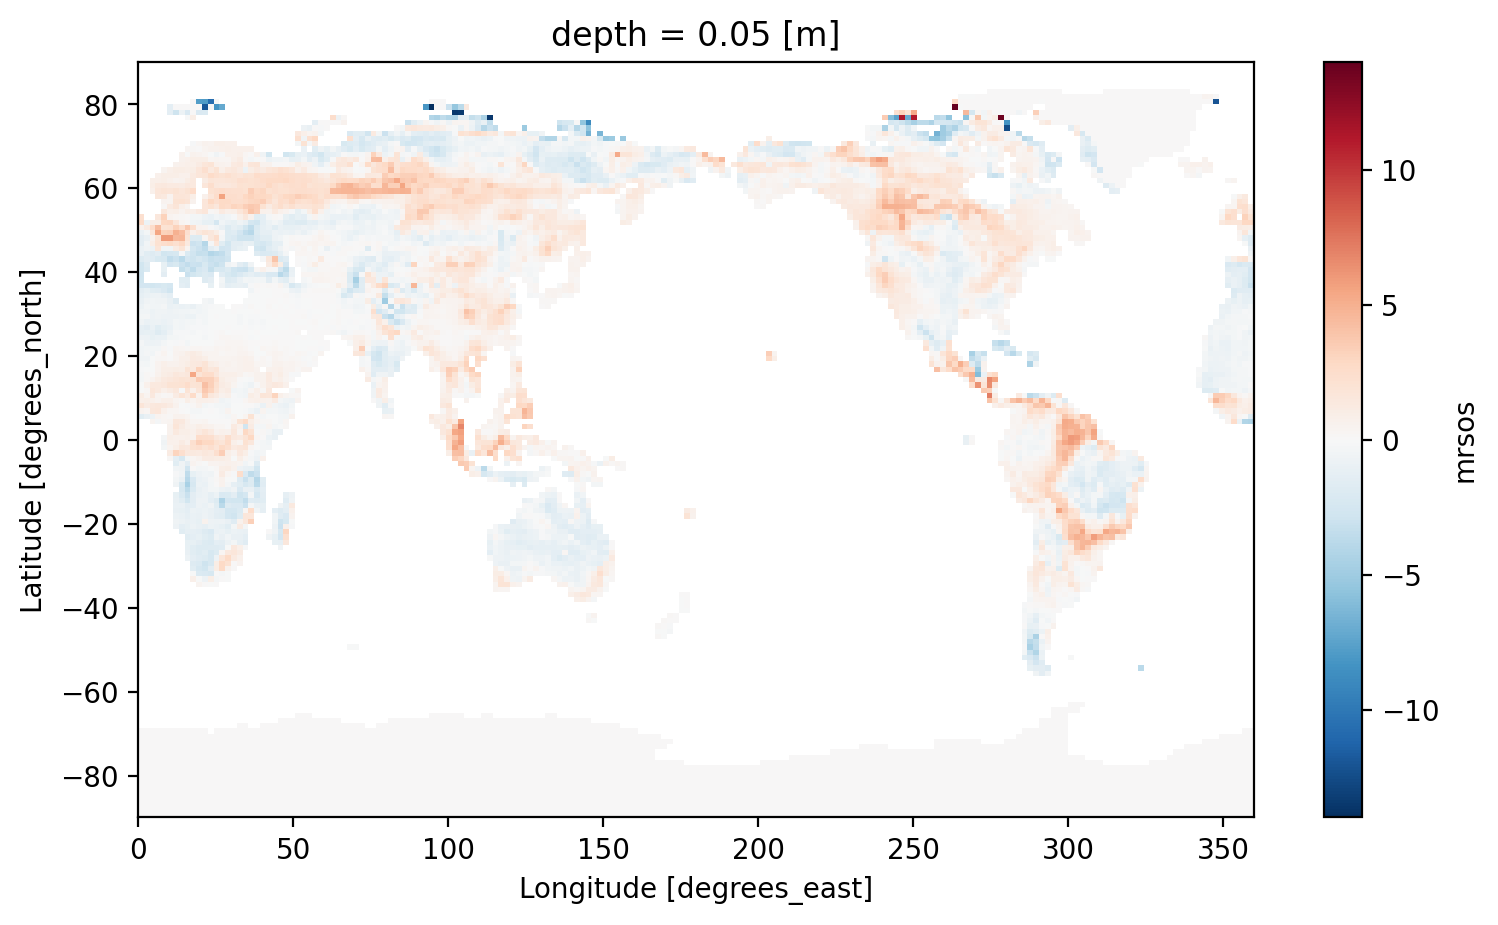

In [34]:
f = plt.figure(figsize=(9,5), dpi=200)
(dafut-dahist).plot()